Title: The prediction of the knowledge of users (UNS) by their exam performance for related objects with goal object (LPR), their exam performance for goal object (PEG)

Introduction

We are trying to set up a model that answers the predictive question of whether the category of the knowledge level of users (UNS) could be predicted by two variables, their exam performance for related objects with goal object (LPR), their exam performance for goal object (PEG) (both continuous data), in which all of the variables are from the dataset "modeling_data_xlsx". We would do this by running classification analysis for the three variables using the k-nearest neighbour algorithm. This could be significant since it could possibly show the relationship between exam scores and users' knowledge level. If this were to be true, then we would learn that we could utilize exams to test someone's knowledge level. Besides, by the correlation results, we could know whether the exam performance of users on goal objects or related objects are better predictors to UNS. This could possibly inspire future users on which object to focus on to optimize their knowledge level.

Terminology

- Response variable:
   -  UNS: Categorical variable, represents the knowledge level of the users.

- Predictive variables:
    - LPR (Learning Performance Rating): Continuous variable, the exam performance of the user for related objects with the goal object.
    - PEG: Continuous Variable, the exam performance of the user for goal objects.

Preliminary exploratory data analysis below

In [22]:
#loading packages
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [23]:
#reading the data
modeling_data <- read_excel("modeling_data_xlsx.xlsx")
modeling_data 

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [24]:
#cleaning the data
modeling_data_selected <- select(modeling_data, LPR, PEG, UNS)
modeling_data_selected

LPR,PEG,UNS
<dbl>,<dbl>,<chr>
0.00,0.00,very_low
0.24,0.90,High
0.25,0.33,Low
⋮,⋮,⋮
0.29,0.77,High
0.61,0.26,Middle
0.87,0.74,High


In [25]:
#splitting into training and testing data
set.seed(1)

modeling_split <- initial_split(modeling_data_selected, prop = 0.75, strata = UNS) 
modeling_training <- training(modeling_split) 
modeling_testing <- testing(modeling_split)

modeling_split
modeling_training
modeling_testing

<Training/Testing/Total>
<192/66/258>

LPR,PEG,UNS
<dbl>,<dbl>,<chr>
0.00,0.0,very_low
0.24,0.9,High
0.35,0.8,High
⋮,⋮,⋮
0.31,0.50,Middle
0.19,0.60,Middle
0.61,0.26,Middle


LPR,PEG,UNS
<dbl>,<dbl>,<chr>
0.29,0.56,Middle
0.20,0.85,High
0.30,0.81,High
⋮,⋮,⋮
0.30,0.52,Middle
0.65,0.25,Middle
0.89,0.88,High


In [26]:
#summarize the data (number of observations)
nrow(modeling_data_selected)

[1] 258

In [27]:
#summarize the data (mean)
modeling_data_summarize <- summarize(modeling_training, 
                                     mean_LPR = mean(LPR),
                                    mean_PEG = mean(PEG),
                                     )
modeling_data_summarize

mean_LPR,mean_PEG
<dbl>,<dbl>
0.425,0.4568385


In [28]:
#summarize the data (min, max)
modeling_data_summarize <- summarize(modeling_training, 
                                     min_LPR = min(LPR),
                                    min_PEG = min(PEG),
                                    max_LPR = max(LPR),
                                    max_PEG = max(PEG),
                                    )
modeling_data_summarize

min_LPR,min_PEG,max_LPR,max_PEG
<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.98,0.93


In [29]:
#summarize the data (standard deviation)
modeling_data_summarize <- summarize(modeling_training, 
                                    sd_LPR = sd(LPR),
                                     sd_PEG = sd(PEG)
                                    )
modeling_data_summarize

sd_LPR,sd_PEG
<dbl>,<dbl>
0.2511627,0.260728


In [9]:
#change colours to colour-blindness friendly

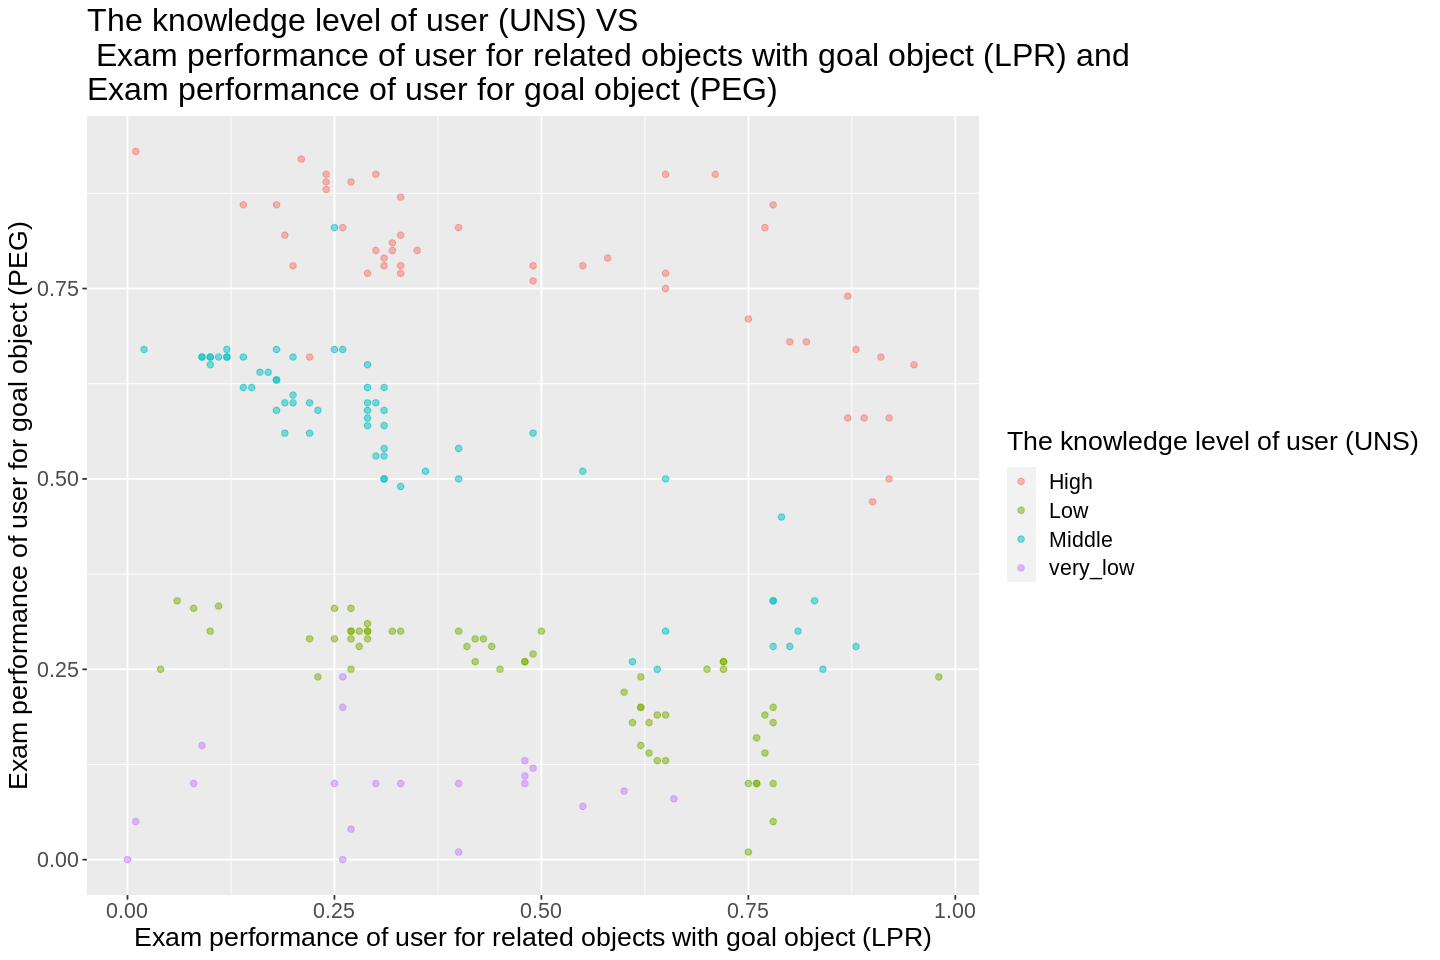

In [31]:
#visualising the data of UNS vs STG and SCG (Variables are yet standardized)
options(repr.plot.width = 12, repr.plot.height = 8)

modeling_data_plot <- ggplot(modeling_training, aes(x = LPR, y = PEG, colour = UNS)) +
        geom_point(alpha = 0.5) +
        labs(x = "Exam performance of user for related objects with goal object (LPR)", y = "Exam performance of user for goal object (PEG)" , colour = "The knowledge level of user (UNS)") +
        ggtitle("The knowledge level of user (UNS) VS \n Exam performance of user for related objects with goal object (LPR) and \nExam performance of user for goal object (PEG)") +
        theme(text = element_text(size = 16))

modeling_data_plot

In [33]:
#create recipe for training data, a specification for k

set.seed(1)
modeling_recipe <- recipe(UNS ~ LPR + PEG, data = modeling_training) |> 
step_scale(all_predictors()) |>
step_center(all_predictors())

modeling_recipe



Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [34]:
set.seed(1)

modeling_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |> 
set_mode("classification")

modeling_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [36]:
#5-fold cross-validation, choose the number of neighbors via the maximum accuracy: (WE WOULD CONTINUE ON THIS LATER)
set.seed(1)
modeling_vfold <- vfold_cv(modeling_training, v = 5, strata = UNS) 
modeling_vals <- tibble(neighbors = seq(1, 101, by = 5)) 

modeling_workflow <- workflow() |> 
    add_recipe(modeling_recipe) |> 
    add_model(modeling_spec) |>
    tune_grid(resamples = modeling_vfold, grid = modeling_vals) |> 
    collect_metrics() 

modeling_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9476029,5,0.008787816,Preprocessor1_Model01
1,roc_auc,hand_till,0.9610399,5,0.012260026,Preprocessor1_Model01
6,accuracy,multiclass,0.9480151,5,0.008029494,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
96,roc_auc,hand_till,0.8167346,5,0.01451846,Preprocessor1_Model20
101,accuracy,multiclass,0.4785035,5,0.03159243,Preprocessor1_Model21
101,roc_auc,hand_till,0.8164004,5,0.01412639,Preprocessor1_Model21


In [37]:
accuracies <- modeling_workflow |>
        filter(.metric == "accuracy")|>
        arrange(desc(mean))

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,multiclass,0.9480151,5,0.008029494,Preprocessor1_Model02
1,accuracy,multiclass,0.9476029,5,0.008787816,Preprocessor1_Model01
11,accuracy,multiclass,0.9224888,5,0.013089744,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,accuracy,multiclass,0.4890298,5,0.03074111,Preprocessor1_Model19
96,accuracy,multiclass,0.4786384,5,0.02642746,Preprocessor1_Model20
101,accuracy,multiclass,0.4785035,5,0.03159243,Preprocessor1_Model21


In [40]:
#Choose the optimal K to run the full analyis on test

modeling_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 6)|>
        set_engine("kknn") |> 
        set_mode("classification")

modeling_workflow_fit <- workflow()|> 
        add_recipe(modeling_recipe) |>
        add_model(modeling_spec_2) |> 
        fit(data = modeling_training)

In [ ]:
set.seed(1)

modeling_predict <- modeling_workflow_fit |> 
        predict(modeling_testing) |> 
        bind_cols(modeling_testing)|>
        select.estimate) |>
        pull()

modeling_mericts <- metrics(modeling_predict, truth = UNS, estimate = .pred_class) |> 
    filter(.metric == 'accuracy')

knn_mult_mets

Methods

We will use the publicly available data "modeling_data_xlsx" on studying and knowledge level from the University of California. We selected the variables STG, SCG, STR, and UNS. In particular, the predictors would be STG, SCG, and STR, all continous, while the response variable would be the categorical variable UNS. We are going to split the data into training set and testing set with the ratio 3:1 on random, and carry out classification analysis using the k-nearest neighbours algorithm, with 5-fold cross-validation on the training set. We will pick the optimal k-value with the highest accuracy, and carry out predictions on UNS on the testing set. We will then re-evaluate the accuracy of our prediction model by computing its prediction accuracy (calculated by dividing the number of correct predictons by the total number of predictions). To visulize our results, we would graph two 2D scatter-plots, one for UNS vs scaled STG and scaled SCG and another for UNS vs scaled STG and scaled STR. We also show its confusion matrix to further evaluate its usefulness, and determine if the three independent variables are strong predictors of UNS.


Expected outcomes and significance

We expect there be positive relationships of the response variable, UNS, with all three of the predictors (STG, STR, SCG), with the relationship possibly being non-linear, due to diminishing marginal returns. We expect our model to have a predictive accuracy of 80% or more. 

We expect our findings could possibly inspire ourselves and our classmates on what the optimal study time and repeition on reviewing lecture notes should be, in order to gain the knowledge level we would want.

This could lead to the future question of how such knowledge could correlate to job success, in order to link study time and repetitive work with job success. 
